In [149]:
import os
from pydub import AudioSegment
import numpy as np

def change_speed(sound, speed=1.0):
    """Ses hızını değiştirme"""
    sound = sound._spawn(sound.raw_data)
    sound = sound.set_frame_rate(int(sound.frame_rate * speed))
    return sound

def change_pitch_with_pydub(sound, pitch_factor=1.0):
    """Pydub kullanarak pitch değiştirme"""
    new_sample_rate = int(sound.frame_rate * (2 ** pitch_factor))
    sound = sound._spawn(sound.raw_data, overrides={'frame_rate': new_sample_rate})
    return sound

def add_noise(sound, noise_level=0.005):
    """Ses dosyasına gürültü ekleme"""
    samples = np.array(sound.get_array_of_samples())
    noise = np.random.normal(0, noise_level, len(samples))
    noisy_samples = samples + noise
    noisy_samples = np.clip(noisy_samples, -32768, 32767)  # 16-bit PCM
    sound = AudioSegment(
        noisy_samples.astype(np.int16).tobytes(),
        frame_rate=sound.frame_rate,
        sample_width=2,
        channels=sound.channels,
    )
    return sound

def save_augmented_sound(sound, output_path):
    """Çoğaltılmış ses dosyasını kaydetme"""
    sound.export(output_path, format="wav")

def augment_audio(input_file, output_dir, person, sub_folder):
    """Ses dosyasını çoğaltma ve etiketleme"""
    sound = AudioSegment.from_wav(input_file)
    
    # Veri artırma işlemleri
    augmented_sounds = []
    
    # Hız değişikliği
    augmented_sounds.append(change_speed(sound, speed=1.2))
    augmented_sounds.append(change_speed(sound, speed=0.8))
    
    # Pitch değişikliği
    augmented_sounds.append(change_pitch_with_pydub(sound, pitch_factor=0.2))
    augmented_sounds.append(change_pitch_with_pydub(sound, pitch_factor=-0.2))
    
    # Gürültü ekleme
    augmented_sounds.append(add_noise(sound, noise_level=0.01))
    
    # Yeni dosyaları kaydetme
    person_folder = os.path.join(output_dir, person)  # Kişiye ait klasör
    os.makedirs(person_folder, exist_ok=True)
    
    sub_folder_path = os.path.join(person_folder, sub_folder)  # Alt klasör oluşturma (örn. korku, mutlu)
    os.makedirs(sub_folder_path, exist_ok=True)
    
    base_name = os.path.splitext(os.path.basename(input_file))[0]
    
    for i, augmented_sound in enumerate(augmented_sounds):
        output_path = os.path.join(sub_folder_path, f"{base_name}_augmented_{i+1}.wav")
        
        # Eğer dosya zaten varsa, yeni dosya eklemeyin
        if not os.path.exists(output_path):
            save_augmented_sound(augmented_sound, output_path)
            print(f"Saved augmented sound to: {output_path}")  # Çıktı mesajı
        else:
            print(f"File {output_path} already exists, skipping...")  # Dosya mevcutsa, mesaj yazdır

def process_all_folders(directory):
    """Klasör yapısındaki her dosyayı dolaşarak ses çoğaltma işlemi yapma"""
    output_dir = "augmented_sounds"  # Çoğaltılmış ses dosyalarının kaydedileceği ana klasör
    for person in os.listdir(directory):
        person_path = os.path.join(directory, person)
        if os.path.isdir(person_path):  # Kişi klasörlerini kontrol et
            # Alt klasörleri (örneğin korku, mutlu) işleyelim
            for sub_folder in os.listdir(person_path):
                sub_folder_path = os.path.join(person_path, sub_folder)
                if os.path.isdir(sub_folder_path):  # Alt klasörleri kontrol et
                    for file in os.listdir(sub_folder_path):
                        if file.endswith('.wav'):
                            file_path = os.path.join(sub_folder_path, file)
                            
                            # Ses dosyasını çoğaltma
                            print(f"Processing {file_path}...")
                            augment_audio(file_path, output_dir, person, sub_folder)  # Ses dosyasını çoğaltma

# Örnek kullanım
directory = "..\Voice"  # Ses dosyalarınızın bulunduğu ana klasör (örn. "irem", "elif", "nazli" klasörleri içinde)
process_all_folders(directory)


Processing ..\Voice\elif\korku\elifkorku1.wav...
File augmented_sounds\elif\korku\elifkorku1_augmented_1.wav already exists, skipping...
File augmented_sounds\elif\korku\elifkorku1_augmented_2.wav already exists, skipping...
File augmented_sounds\elif\korku\elifkorku1_augmented_3.wav already exists, skipping...
File augmented_sounds\elif\korku\elifkorku1_augmented_4.wav already exists, skipping...
File augmented_sounds\elif\korku\elifkorku1_augmented_5.wav already exists, skipping...
Processing ..\Voice\elif\korku\elifkorku2.wav...
File augmented_sounds\elif\korku\elifkorku2_augmented_1.wav already exists, skipping...
File augmented_sounds\elif\korku\elifkorku2_augmented_2.wav already exists, skipping...
File augmented_sounds\elif\korku\elifkorku2_augmented_3.wav already exists, skipping...
File augmented_sounds\elif\korku\elifkorku2_augmented_4.wav already exists, skipping...
File augmented_sounds\elif\korku\elifkorku2_augmented_5.wav already exists, skipping...
Processing ..\Voice\el

In [150]:
import librosa
import numpy as np
import os
import pandas as pd

def extract_features(file_path):
    try:
        # Ses dosyasını yükleyin
        y, sr = librosa.load(file_path, sr=None)
        
        # MFCC (Mel-frequency cepstral coefficients) çıkarımı
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)  # MFCC ortalamasını al

        # Chroma çıkarımı (sesin müzikal tonları hakkında bilgi verir)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # RMS Energy çıkarımı
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)

        # Zero-Crossing Rate çıkarımı
        zcr = librosa.feature.zero_crossing_rate(y=y)
        zcr_mean = np.mean(zcr)
        
        # Özellikleri birleştir
        features = np.hstack((mfcc_mean, chroma_mean, rms_mean, zcr_mean))
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def process_audio_files(directory):
    features_list = []
    labels = []
    
    for person in os.listdir(directory):
        person_path = os.path.join(directory, person)
        if os.path.isdir(person_path):
            for sub_folder in os.listdir(person_path):
                sub_folder_path = os.path.join(person_path, sub_folder)
                if os.path.isdir(sub_folder_path):
                    for file in os.listdir(sub_folder_path):
                        if file.endswith('.wav'):
                            file_path = os.path.join(sub_folder_path, file)
                            
                            print(f"Processing file: {file_path}")
                            features = extract_features(file_path)
                            
                            if features is not None:
                                features_list.append(features)
                                labels.append(person)
                            else:
                                print(f"Skipping {file_path} due to error in feature extraction.")
    
    if features_list:
        # Özellikleri ve etiketleri bir DataFrame'e dönüştürme
        features_df = pd.DataFrame(features_list)
        features_df['label'] = labels
        return features_df
    else:
        print("No features extracted.")
        return pd.DataFrame()

# Örnek kullanım
directory = "augmented_sounds"  # Ses dosyalarınızın bulunduğu ana klasör
features_df = process_audio_files(directory)

# Özellikleri bir CSV dosyasına kaydedelim
try:
    if not features_df.empty:
        features_df.to_csv('audio_features.csv', index=False)
        print("Features extracted and saved to 'audio_features.csv'.")
    else:
        print("No features to save.")
except Exception as e:
    print(f"Error saving to CSV: {e}")

# Özelliklerin doğruluğunu kontrol et
print(features_df.head())  # İlk birkaç satırı görüntüleyin
print(features_df.info())  # Veri tipleri ve eksik değerler hakkında bilgi


Processing file: augmented_sounds\elif\korku\elifkorku1_augmented_1.wav
Processing file: augmented_sounds\elif\korku\elifkorku1_augmented_2.wav
Processing file: augmented_sounds\elif\korku\elifkorku1_augmented_3.wav
Processing file: augmented_sounds\elif\korku\elifkorku1_augmented_4.wav
Processing file: augmented_sounds\elif\korku\elifkorku1_augmented_5.wav
Processing file: augmented_sounds\elif\korku\elifkorku2_augmented_1.wav
Processing file: augmented_sounds\elif\korku\elifkorku2_augmented_2.wav
Processing file: augmented_sounds\elif\korku\elifkorku2_augmented_3.wav
Processing file: augmented_sounds\elif\korku\elifkorku2_augmented_4.wav
Processing file: augmented_sounds\elif\korku\elifkorku2_augmented_5.wav
Processing file: augmented_sounds\elif\korku\elifkorku3_augmented_1.wav
Processing file: augmented_sounds\elif\korku\elifkorku3_augmented_2.wav
Processing file: augmented_sounds\elif\korku\elifkorku3_augmented_3.wav
Processing file: augmented_sounds\elif\korku\elifkorku3_augmente

In [151]:
import pandas as pd

# CSV dosyasını yükleyin
file_path = 'audio_features.csv'  # Dosya yolunuza göre değiştirin
df = pd.read_csv(file_path)

# Veriyi kontrol edin
print(df.head())  # İlk 5 satırı kontrol et
print(df.info())  # Veri hakkında daha fazla bilgi


            0           1          2          3         4         5         6  \
0 -449.398438  149.738174  33.502274  37.630802  6.537011  4.192473  5.072884   
1 -425.292908  140.695465  33.069122  33.527046 -1.442215  8.761436 -0.853979   
2 -436.414246  148.805756  31.636620  34.794178 -3.080543  6.789721 -0.098044   
3 -437.715607  138.920410  33.214138  41.411243  4.500316  9.638011  2.671160   
4 -437.686768  144.676712  32.395496  38.448486  0.469348  8.006750  1.131749   

          7         8         9  ...        18        19        20        21  \
0 -0.110211  2.216745 -6.012776  ...  0.504198  0.569895  0.587655  0.566525   
1  2.955790 -6.229181 -2.189412  ...  0.468853  0.511972  0.457637  0.456830   
2  0.634965 -3.692470 -8.287903  ...  0.228517  0.278435  0.365580  0.505160   
3  3.098497  1.381426 -4.988506  ...  0.509862  0.512549  0.490459  0.494607   
4  2.105063 -0.937292 -6.280627  ...  0.498021  0.556974  0.512546  0.514603   

         22        23        24 

In [152]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

# Özellikleri içeren CSV dosyasını yükleyin
features_df = pd.read_csv('audio_features.csv')

# Özelliklerin doğruluğunu kontrol et
print("Veri seti ilk satırları (güncelleme öncesi):")
print(features_df.head())  # İlk birkaç satırı görüntüleyin
print(features_df.info())  # Veri tipleri ve eksik değerler hakkında bilgi

# Adım 1: Etiket sütununu ayırma
label_column = 'label'  # Etiket sütununun adı
labels = features_df[label_column]  # Etiket sütunu
features_df = features_df.drop(columns=[label_column])  # Etiketi veri setinden çıkar

# Adım 2: Özellikleri Normalize Etme (Min-Max Normalizasyonu)
scaler = MinMaxScaler()

# Tüm satırları normalize et ve DataFrame'i güncelle
normalized_features = scaler.fit_transform(features_df)
features_df = pd.DataFrame(normalized_features, columns=features_df.columns)

# Etiket sütununu geri ekleme
features_df[label_column] = labels

# Scaler'ı kaydetme
scaler_filename = 'scaler.joblib'
joblib.dump(scaler, scaler_filename)  # Scaler'ı kaydediyoruz
print(f"Scaler kaydedildi: {scaler_filename}")

# Güncellenmiş veri setini kaydet
features_df.to_csv('audio_features_normalized.csv', index=False)
print("Güncellenmiş veri seti 'audio_features_normalized.csv' dosyasına kaydedildi.")

# Adım 3: X (özellikler) ve y (etiketler) ayrıştırma
feature_columns = features_df.columns[:-1]  # Son sütun etiket olduğu için, özellik sütunlarını seçiyoruz
X = features_df[feature_columns].values  # Özellikler (numpy array olarak)
y = features_df[label_column].values  # Etiketler (numpy array olarak)

# Eğitim ve test verilerini ayırma (80% eğitim, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X ve y oluşturuldu ve eğitim/test verileri ayrıldı.")
print(f"X_train boyutu: {X_train.shape}, X_test boyutu: {X_test.shape}")
print(f"y_train boyutu: {y_train.shape}, y_test boyutu: {y_test.shape}")


Veri seti ilk satırları (güncelleme öncesi):
            0           1          2          3         4         5         6  \
0 -449.398438  149.738174  33.502274  37.630802  6.537011  4.192473  5.072884   
1 -425.292908  140.695465  33.069122  33.527046 -1.442215  8.761436 -0.853979   
2 -436.414246  148.805756  31.636620  34.794178 -3.080543  6.789721 -0.098044   
3 -437.715607  138.920410  33.214138  41.411243  4.500316  9.638011  2.671160   
4 -437.686768  144.676712  32.395496  38.448486  0.469348  8.006750  1.131749   

          7         8         9  ...        18        19        20        21  \
0 -0.110211  2.216745 -6.012776  ...  0.504198  0.569895  0.587655  0.566525   
1  2.955790 -6.229181 -2.189412  ...  0.468853  0.511972  0.457637  0.456830   
2  0.634965 -3.692470 -8.287903  ...  0.228517  0.278435  0.365580  0.505160   
3  3.098497  1.381426 -4.988506  ...  0.509862  0.512549  0.490459  0.494607   
4  2.105063 -0.937292 -6.280627  ...  0.498021  0.556974  0.512546  

Model doğruluğu: 94.85%


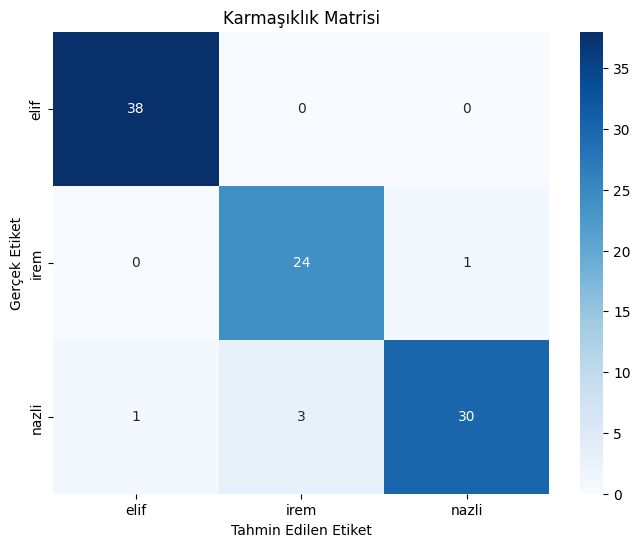

In [226]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Adım 3: Modeli Eğitme (Random Forest)
model = RandomForestClassifier(n_estimators=15, random_state=40,class_weight='balanced')
model.fit(X_train, y_train)

# Adım 4: Modeli Test Etme
y_pred = model.predict(X_test)

# Adım 5: Doğruluk Hesaplama
accuracy = accuracy_score(y_test, y_pred)
print(f"Model doğruluğu: {accuracy * 100:.2f}%")

# Adım 6: Karmaşıklık Matrisi
cm = confusion_matrix(y_test, y_pred)

# Isı haritası ile karmaşıklık matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.show()


In [227]:
import joblib

# Modeli kaydetme
model_filename = 'random_forest_model.joblib'
joblib.dump(model, model_filename)
print(f"Model kaydedildi: {model_filename}")


Model kaydedildi: random_forest_model.joblib


In [228]:
# Modeli yükleme
loaded_model = joblib.load(model_filename)
print("Model başarıyla yüklendi.")


Model başarıyla yüklendi.


In [229]:
import joblib
import librosa
import numpy as np

# Scaler ve model dosyalarını yükleme
scaler_filename = 'scaler.joblib'
model_filename = 'random_forest_model.joblib'
scaler = joblib.load(scaler_filename)
model = joblib.load(model_filename)

def extract_features_for_prediction(file_path):
    """Ses dosyasından özellikleri çıkar."""
    try:
        # Ses dosyasını yükle
        y, sr = librosa.load(file_path, sr=None)
        
        # MFCC (Mel-frequency cepstral coefficients) çıkarımı
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Chroma çıkarımı (müzikal tonlar)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # RMS Energy çıkarımı
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)

        # Zero-Crossing Rate çıkarımı
        zcr = librosa.feature.zero_crossing_rate(y=y)
        zcr_mean = np.mean(zcr)
        
        # Özellikleri birleştir
        features = np.hstack((mfcc_mean, chroma_mean, rms_mean, zcr_mean))
        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def predict_audio_with_scaler(file_path):
    """Ses dosyasını scaler ve model ile test et."""
    # Özellik çıkarma
    features = extract_features_for_prediction(file_path)
    if features is None:
        print("Özellik çıkarma başarısız.")
        return

    # Özellikleri normalize et
    features = features.reshape(1, -1)  # Modelin tahmin yapabilmesi için 2D array haline getir
    normalized_features = scaler.transform(features)

    # Model ile tahmin yap
    prediction = model.predict(normalized_features)
    print(f"Tahmin edilen etiket: {prediction[0]}")

# Test edilecek ses dosyası
test_file = "C:\VoiceProject\Voice\irem\korku\Iremkorku1.wav"  # Test ses dosyasının tam yolunu yazın
predict_audio_with_scaler(test_file)


Tahmin edilen etiket: irem


c:\Users\iremm\.conda\envs\BTK-AI\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [203]:
import numpy as np
import joblib
import librosa
import sounddevice as sd

# Model ve scaler dosyalarını yükleme
scaler_filename = 'scaler.joblib'
model_filename = 'random_forest_model.joblib'
model = joblib.load(model_filename)

# Eğitim sırasında belirlenmiş min ve max değerler
FEATURE_MIN = np.array([0] * 27)  # Eğitim verilerinizden gelen minimum değerler
FEATURE_MAX = np.array([1] * 27)  # Eğitim verilerinizden gelen maksimum değerler

# Ses kaydetme fonksiyonu
def record_audio(duration=5, fs=16000):
    """Mikrofondan ses kaydet."""
    print("Ses kaydediliyor...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print("Ses kaydı tamamlandı.")
    return recording.flatten()

# Özellik çıkarma fonksiyonu
def extract_features_for_prediction(y, sr=16000):
    """Ses verisinden özellikleri çıkar."""
    try:
        # MFCC (Mel-frequency cepstral coefficients) çıkarımı
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Chroma çıkarımı (müzikal tonlar)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # RMS Energy çıkarımı
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)

        # Zero-Crossing Rate çıkarımı
        zcr = librosa.feature.zero_crossing_rate(y=y)
        zcr_mean = np.mean(zcr)
        
        # Özellikleri birleştir
        features = np.hstack((mfcc_mean, chroma_mean, [rms_mean], [zcr_mean]))  # RMS ve ZCR tek değer
        return features

    except Exception as e:
        print(f"Hata oluştu: {e}")
        return None

# Özellikleri normalize etme
def normalize_features(features):
    """Manuel olarak özellikleri 0 ile 1 arasına çek."""
    if features.shape[0] != FEATURE_MIN.shape[0]:
        print(f"Özellik boyutları uyuşmuyor: features={features.shape[0]}, min/max={FEATURE_MIN.shape[0]}")
        return None
    try:
        normalized_features = (features - FEATURE_MIN) / (FEATURE_MAX - FEATURE_MIN)
        return normalized_features
    except Exception as e:
        print(f"Normalizasyon sırasında hata oluştu: {e}")
        return None

# Tahmin yapma fonksiyonu
def predict_audio(audio_data, sr=16000):
    """Manuel normalizasyon ile tahmin yap."""
    # Özellik çıkarma
    features = extract_features_for_prediction(audio_data, sr)
    if features is None:
        print("Özellik çıkarma başarısız.")
        return

    # Özellikleri manuel olarak normalize et
    normalized_features = normalize_features(features)
    if normalized_features is None:
        print("Normalizasyon başarısız.")
        return

    # Özellikleri yeniden şekillendir
    normalized_features = normalized_features.reshape(1, -1)  # Modelin tahmin yapabilmesi için 2D array haline getir

    # Model ile tahmin yap
    prediction = model.predict(normalized_features)
    print(f"Tahmin edilen etiket: {prediction[0]}")

# Mikrofonla ses kaydedip tahmin yapma
audio_data = record_audio(duration=3, fs=16000)  # 5 saniye ses kaydı
predict_audio(audio_data)


Ses kaydediliyor...
Ses kaydı tamamlandı.
Tahmin edilen etiket: elif


In [247]:
import numpy as np
import librosa
import soundfile as sf
import sounddevice as sd
import noisereduce as nr
import joblib

# Scaler ve model dosyalarını yükleme
scaler_filename = 'scaler.joblib'
model_filename = 'random_forest_model.joblib'
scaler = joblib.load(scaler_filename)
model = joblib.load(model_filename)

def record_audio(duration=5, fs=16000):
    """Mikrofondan ses kaydet ve .wav formatına dönüştür."""
    print("Ses kaydediliyor...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print("Ses kaydı tamamlandı.")
    return recording.flatten(), fs

def reduce_noise(audio, sr):
    """Gürültü azaltma işlemi uygula."""
    noise_sample = audio[:sr]  # İlk 1 saniyeyi gürültü örneği olarak al
    reduced_audio = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_sample)
    return reduced_audio

def extract_features_for_prediction(audio, sr=16000):
    """Ses verisinden özellikleri çıkar."""
    try:
        # MFCC (Mel-frequency cepstral coefficients) çıkarımı
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Chroma çıkarımı (müzikal tonlar)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # RMS Energy çıkarımı
        rms = librosa.feature.rms(y=audio)
        rms_mean = np.mean(rms)

        # Zero-Crossing Rate çıkarımı
        zcr = librosa.feature.zero_crossing_rate(y=audio)
        zcr_mean = np.mean(zcr)
        
        # Özellikleri birleştir
        features = np.hstack((mfcc_mean, chroma_mean, [rms_mean], [zcr_mean]))  # RMS ve ZCR tek değer
        return features

    except Exception as e:
        print(f"Hata oluştu: {e}")
        return None

def predict_audio_with_scaler(audio, sr=16000):
    """Mikrofondan alınan sesi scaler ve model ile test et."""
    # Gürültü azaltma
    reduced_audio = reduce_noise(audio, sr)

    # Özellik çıkarma
    features = extract_features_for_prediction(reduced_audio, sr)
    if features is None:
        print("Özellik çıkarma başarısız.")
        return

    # Özellikleri normalize et
    features = features.reshape(1, -1)  # Modelin tahmin yapabilmesi için 2D array haline getir
    normalized_features = scaler.transform(features)

    # Model ile tahmin yap
    prediction = model.predict(normalized_features)
    print(f"Tahmin edilen etiket: {prediction[0]}")

# Mikrofonla ses kaydedip tahmin yapma
audio_data, sample_rate = record_audio(duration=5, fs=16000)  # 5 saniye ses kaydı
predict_audio_with_scaler(audio_data, sample_rate)


Ses kaydediliyor...
Ses kaydı tamamlandı.
Tahmin edilen etiket: irem


c:\Users\iremm\.conda\envs\BTK-AI\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
